#### Machine Learning

In [7]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, cross_val_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector
import sys
sys.path.append('..')
from Cleaning_and_Evaluation import *

In [8]:
df = pd.read_csv("../../data/400-1800_with_raw_scaled_surface_pagerank.csv")

Filter the least central spectra

In [9]:
df = df[df['PageRank'] > 0.926659530655764]
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank
4098,201210-1-02,293,400.22778,2182.6694,201210-1,Normal,0.961147
4099,201210-1-02,294,400.91116,2149.6565,201210-1,Normal,0.961147
4100,201210-1-02,295,401.59454,2146.0227,201210-1,Normal,0.961147
4101,201210-1-02,296,402.27789,2159.3459,201210-1,Normal,0.961147
4102,201210-1-02,297,402.96127,2167.2910,201210-1,Normal,0.961147
...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,1.201164
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,1.201164
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,1.201164
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,1.201164


In [10]:
cleaning_params = {
    'despike': False,
    'baseline_correct': True,
    'smoothing': True,
    'scaling': 'snv',
    'despike_ma': 10,
    'despike_threshold': 7,
    'lam': 10**10,
    'p': 0.057,
    'window_size': 77,
    'poly_order': 5
}
spectra_cleaning(df, **cleaning_params)

df

Get the representative spectra.

In [6]:
df = df[df['PageRank'] > pagerank_cutoff]

In [7]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [8]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy',groups=groups)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [9]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [10]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-02,0.017863,0.013682,0.013220,0.014904,0.015908,0.015108,0.013165,0.011713,0.012803,0.012270,...,-0.010885,-0.009263,-0.008343,-0.010486,-0.010885,-0.008507,-0.011137,-0.011519,201210-1,Normal
201210-1-03,0.008131,0.007215,0.006732,0.007461,0.008760,0.009256,0.008747,0.009569,0.008425,0.006655,...,-0.013168,-0.011258,-0.012561,-0.012035,-0.012255,-0.011570,-0.010250,-0.012605,201210-1,Normal
201210-1-09,0.046859,0.046642,0.045952,0.047187,0.048798,0.049238,0.049117,0.047301,0.044032,0.044617,...,0.003476,0.001585,0.000748,-0.001545,0.002849,0.002106,0.005491,-0.001502,201210-1,Normal
201210-1-14,0.022741,0.022780,0.021316,0.019457,0.019873,0.022090,0.021775,0.019513,0.018773,0.019976,...,-0.009345,-0.010812,-0.013236,-0.014604,-0.008844,-0.008403,-0.011212,-0.011380,201210-1,Normal
201210-1-15,0.028340,0.028478,0.028225,0.030759,0.030517,0.025543,0.023832,0.029062,0.028080,0.035007,...,-0.009158,-0.009699,-0.008715,-0.012308,-0.011865,-0.009489,-0.009116,-0.005938,201210-1,Normal


In [11]:
def evaluate_random_forest(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Random Forest classifier
    rf = RandomForestClassifier(random_state=1234, criterion='entropy', max_depth=23, n_estimators=78)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # Getting cross-validation scores
    scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy',groups=groups, n_jobs=-1)
    
    # Displaying the results
    print(f'{rf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [12]:
evaluate_random_forest(wavelength_df)

RandomForestClassifier Cross-Validation Accuracy: 0.6966 +/- 0.1481


##### **Greedy Feature Selection**

In [13]:
# Set the Surfaces as groups
groups = wavelength_df['SurID']
X = wavelength_df.drop(['Status', 'SurID'], axis=1)
y = wavelength_df['Status']

# Creating the Random Forest classifier
rf = RandomForestClassifier(random_state=1234, criterion='entropy', max_depth=23, n_estimators=78)

# Using GroupKFold for classification tasks
cv = GroupKFold(n_splits=5)

# Feature selector
sfs = SequentialFeatureSelector(rf,
                                k_features=(1, 60),
                                    forward=True,
                                    scoring='accuracy',
                                    cv=cv,
                                    n_jobs=-1,
                                    verbose=2)

# Fit the feature selector
sfs = sfs.fit(X, y, groups=groups)

# Get selected feature names
selected_feature_names = X[list(sfs.k_feature_names_)]

# Create a DataFrame with selected features
selected_features_df = pd.DataFrame(selected_feature_names.columns, columns=['Selected Features'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 2049 out of 2049 | elapsed:  5.2min finished

[2024-04-13 19:13:11] Features: 1/60 -- score: 0.45511220287321114[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]:

In [ ]:
selected_features_df

,Selected Features
0,439.86331
1,507.51709
2,514.35077
3,517.76764
4,520.50116
5,633.9408
6,646.24146
7,659.90887
8,689.29382
9,728.24603


In [ ]:
selected_features_df.to_csv("../../data/outlier_removed_search.csv")

In [ ]:
selected_features_df = selected_features_df.rename(columns={"Selected Features" : "WaveNumber"})

Text(0.5, 1.0, 'Feature Importance and Average Spectra of each Status')

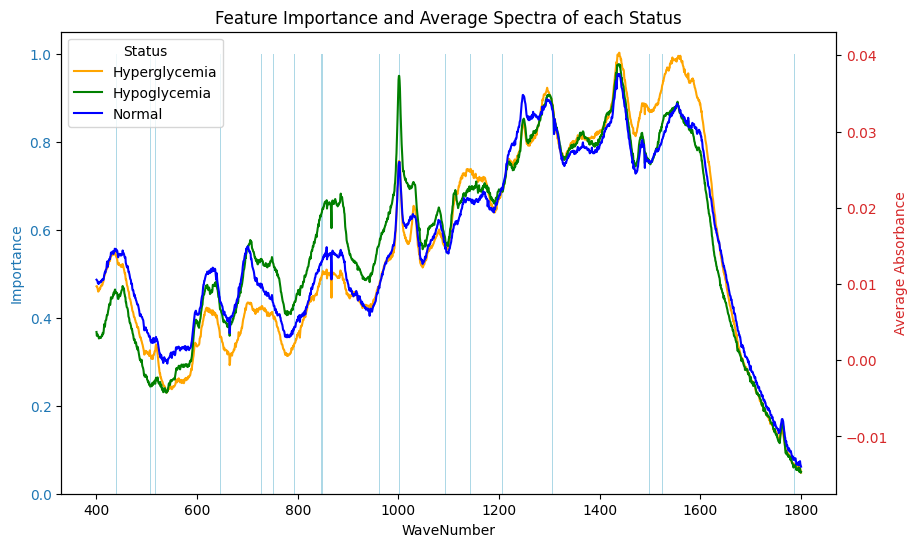

In [ ]:
# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['lightblue'] * len(selected_features_df['WaveNumber'])
ax1.bar(selected_features_df['WaveNumber'], 1, color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Feature Importance and Average Spectra of each Status')

# # Show the plot
# plt.tight_layout()
# plt.show()

In [ ]:
help(SequentialFeatureSelector)

Help on class SequentialFeatureSelector in module mlxtend.feature_selection.sequential_feature_selector:

class SequentialFeatureSelector(mlxtend.utils.base_compostion._BaseXComposition, sklearn.base.MetaEstimatorMixin)
 |  SequentialFeatureSelector(estimator, k_features=1, forward=True, floating=False, verbose=0, scoring=None, cv=5, n_jobs=1, pre_dispatch='2*n_jobs', clone_estimator=True, fixed_features=None, feature_groups=None)
 |  
 |  Sequential Feature Selection for Classification and Regression.
 |  
 |  Parameters
 |  ----------
 |  estimator : scikit-learn classifier or regressor
 |  k_features : int or tuple or str (default: 1)
 |      Number of features to select,
 |      where k_features < the full feature set.
 |      New in 0.4.2: A tuple containing a min and max value can be provided,
 |          and the SFS will consider return any feature combination between
 |          min and max that scored highest in cross-validation. For example,
 |          the tuple (1, 4) will 